In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import seaborn  as sns
import pandas as pd
import geopandas as gpd
import datetime
import string
import random
import pymongo
import folium
import math
from pymongo import MongoClient
from typing import Union,List, Dict, Any
from shapely.geometry import Point
from geopy.distance import great_circle
from typing import Tuple
import requests
import json



In [3]:
df = pd.read_csv('CSV_limpios/data_clean_gps.csv')
df._id = df._id.astype(str)

/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_5756/3219197946.py:1: DtypeWarning: Columns (11,12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CSV_limpios/data_clean_gps.csv')


In [4]:
df

,_id,UUID,dataRowType,createdAt,updatedAt,__v,dataRowData_timestamp,dataRowData_mac,dataRowData_battery,dataRowData_temperature,...,dataRowData_firmwareVersion,dataRowData_lat,dataRowData_lng,dataRowData_gpsAlt,dataRowData_gpsVel,dataRowData_gpsFixed,dataRowData_voltage,dataRowData_charge,dataRowData_temperatureSoC,payload
0,62e93bc957a36c0025d91f21,0004A30B00F80B96,BEACON,2022-08-02 14:59:21.963,2022-08-02 14:59:21.963,0.0,2022-08-02T14:59:21.948Z,4117145F01F4,100.0,30.70,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62e93bee57a36c0025d91f23,0004A30B00F82BD2,GPS,2022-08-02 14:59:58.512,2022-08-02 14:59:58.512,0.0,2022-02-08T14:59:57,NaN,NaN,NaN,...,NaN,-31.475927,-64.193128,456.8,0.064,1.0,NaN,NaN,NaN,NaN
2,62e93bf557a36c0025d91f29,0004A30B00F7FC71,BEACON,2023-02-21 15:00:05.624,2023-02-21 15:00:05.624,0.0,2022-08-02T15:00:05.618Z,0004A30B00F82E81,99.0,25.60,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62e93bf857a36c0025d91f2b,0004A30B00F7FC71,BEACON,2022-08-02 15:00:08.059,2022-08-02 15:00:08.059,0.0,2022-08-02T15:00:08.053Z,A7AA2D0FF0F3,100.0,25.50,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62e93bfa57a36c0025d91f2d,0004A30B00F82BD2,BEACON,2022-08-02 15:00:10.210,2022-08-02 15:00:10.210,0.0,2022-08-02T15:00:10.203Z,4347268646FA,100.0,25.60,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296775,642d9b18d4035700302e32a7,0004A30B00F89C52,BEACON,2023-04-05 16:00:24.058,2023-04-05 16:00:24.058,0.0,2023-05-03T15:43:56,35BE312703D9,89.0,27.01,...,2.02.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.00,770f2b3805031735be312703d9598d0af00aa8e84e0000
1296776,642d9b1bd4035700302e32ad,0004A30B00F89C52,BATTERY,2023-04-05 16:00:27.783,2023-04-05 16:00:27.783,0.0,2023-04-05T16:00:27.781Z,NaN,88.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4089.0,-5.0,NaN,2c51992d64598df90f58fbff
1296777,642d9b20d4035700302e32b3,0004A30B00F89C52,BEACON,2023-04-05 16:00:32.076,2023-04-05 16:00:32.076,0.0,2023-05-03T15:53:49,35BE312703D9,91.0,26.50,...,2.02.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.00,770f353105031735be312703d95b5a0af00ab5e84e0000
1296778,642d9b24d4035700302e32b9,0004A30B00F89C52,BEACON,2023-04-05 16:00:36.318,2023-04-05 16:00:36.318,0.0,2023-05-03T15:53:51,F80B9DF1EFD5,77.0,26.45,...,2.02.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.25,770f3533050317f80b9df1efd54d550a410ab5e84e0000


In [5]:
def filter_data_types(df_row: pd.DataFrame) -> tuple:
    """
    Se seleccionan las filas del DataFrame original donde el valor de la columna 'dataRowType' es 'GPS', 
    'dataRowType' es 'BEACON' y 'dataRowType' es 'BATTERY' y se devuelve una tupla con los tres DataFrames filtrados
    
    Parámetro:
    -----------
    - df_row: DataFrame que contiene los datos a filtrar.

    Retorna:
    --------
    - Diferentes DataFrames, cada uno correspondiente al tipo de origen de dato indicado.
    """

    # Se cargan los valores en funcion de condicion de equivalencia.
    data_gps = df[df.dataRowType == 'GPS']
    data_beacon = df[df.dataRowType == 'BEACON']
    data_battery = df[df.dataRowType == 'BATTERY']
    return (data_gps, data_beacon, data_battery)

data_gps,data_beacon,data_battery = filter_data_types(df)

In [14]:
df_gps=data_gps[['UUID','createdAt','dataRowData_lat','dataRowData_lng','dataRowData_gpsAlt','dataRowData_gpsVel','dataRowData_gpsFixed']]
df_gps['UUID']

,UUID,createdAt,dataRowData_lat,dataRowData_lng,dataRowData_gpsAlt,dataRowData_gpsVel,dataRowData_gpsFixed
1,0004A30B00F82BD2,2022-08-02 14:59:58.512,-31.475927,-64.193128,456.8,0.064,1.0
15,0004A30B00F7FC71,2022-08-02 15:08:00.762,-32.854743,-63.642888,221.7,0.027,1.0
16,0004A30B00F82BD2,2022-08-02 15:10:06.717,-31.476051,-64.193208,472.2,0.047,1.0
28,0004A30B00F825B7,2022-08-02 15:15:12.159,-32.854765,-63.642779,224.1,0.018,1.0
40,0004A30B00F82BD2,2022-08-02 15:20:33.459,-31.475896,-64.193143,0.0,0.066,1.0
...,...,...,...,...,...,...,...
1296759,0004A30B00F81075,2023-04-05 15:47:47.484,-34.205734,-64.031775,194.5,0.565,1.0
1296762,0004A30B00F81069,2023-04-05 15:47:59.018,-34.205717,-64.031736,0.0,0.041,1.0
1296764,0004A30B00F8B217,2023-04-05 15:48:24.747,-34.205669,-64.032002,170.8,0.147,1.0
1296767,0004A30B00F81075,2023-04-05 15:52:02.651,-34.205715,-64.031734,179.1,0.071,1.0


__Conexión con API para nuevas consultas__

In [4]:
response = requests.get('http://127.0.0.1:8000/informacion_por_asentamiento/MACSA')
#datos_Vaca= json.loads(response.text)
#vaca= pd.DataFrame(datos_Vaca)

In [7]:
response

<Response [404]>

In [6]:
#Registros de un establecimiento MACSA

datos_Vaca= json.loads(response.text)
macsa = pd.DataFrame(datos_Vaca)

ValueError: If using all scalar values, you must pass an index

In [42]:
macsa

,UUID,point_ini,point_next,interval_time,distancia,velocidad,tiempo,charge_vel
0,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.025,0.845,0.029,0.845
1,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.018,1.116,0.016,1.546
2,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,2.391,0.004,-0.355
3,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,0.761,0.012,-1.333
4,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-18 14:00:07.309,4,0.056,1.058,0.053,-0.740
...,...,...,...,...,...,...,...,...
4008,0004A30B00F82EB9,2023-03-29 22:35:31.812,2023-03-29 22:35:39.998,0,0.096,0.681,0.140,0.008
4009,0004A30B00F82EB9,2023-03-29 22:35:39.998,2023-03-29 22:44:23.487,0,3.603,0.039,92.395,28.133
4010,0004A30B00F82EB9,2023-03-29 22:44:23.487,2023-03-29 22:54:07.984,0,0.078,28.814,0.003,31.339
4011,0004A30B00F82EB9,2023-03-29 22:54:07.984,2023-03-29 22:56:27.913,0,3.392,31.378,0.108,-28.409


In [43]:
#Registros de cada UUID en ese establecimiento

macsa['UUID'].value_counts()

0004A30B00F89C5D    713
0004A30B00F89C52    541
0004A30B00F83085    523
0004A30B00F8B217    464
0004A30B00F842B6    386
0004A30B00F860CC    320
0004A30B00F81075    265
0004A30B00F81069    217
0004A30B00F86440    178
0004A30B00F82E81    131
0004A30B00F842C1    109
0004A30B00F869B4     79
0004A30B00F8B356     19
0004A30B00F841E4     17
0004A30B00F8A181     13
0004A30B00F7E0C6     13
0004A30B00F82EB9     13
0004A30B00F862AF     12
Name: UUID, dtype: int64

In [44]:
macsa[['Fecha', 'Hora']]= macsa.point_ini.str.split(' ', expand=True)
macsa

,UUID,point_ini,point_next,interval_time,distancia,velocidad,tiempo,charge_vel,Fecha,Hora
0,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.025,0.845,0.029,0.845,2023-02-17,10:00:36.470
1,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.018,1.116,0.016,1.546,2023-02-17,10:00:36.470
2,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,2.391,0.004,-0.355,2023-02-17,10:00:36.470
3,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,0.761,0.012,-1.333,2023-02-17,10:00:36.470
4,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-18 14:00:07.309,4,0.056,1.058,0.053,-0.740,2023-02-17,10:00:36.470
...,...,...,...,...,...,...,...,...,...,...
4008,0004A30B00F82EB9,2023-03-29 22:35:31.812,2023-03-29 22:35:39.998,0,0.096,0.681,0.140,0.008,2023-03-29,22:35:31.812
4009,0004A30B00F82EB9,2023-03-29 22:35:39.998,2023-03-29 22:44:23.487,0,3.603,0.039,92.395,28.133,2023-03-29,22:35:39.998
4010,0004A30B00F82EB9,2023-03-29 22:44:23.487,2023-03-29 22:54:07.984,0,0.078,28.814,0.003,31.339,2023-03-29,22:44:23.487
4011,0004A30B00F82EB9,2023-03-29 22:54:07.984,2023-03-29 22:56:27.913,0,3.392,31.378,0.108,-28.409,2023-03-29,22:54:07.984


In [45]:
macsa['point_ini'] = pd.to_datetime(macsa['point_ini'])
#macsa['Hora'] = pd.to_datetime(macsa['Hora'])

In [46]:
macsa

,UUID,point_ini,point_next,interval_time,distancia,velocidad,tiempo,charge_vel,Fecha,Hora
0,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.025,0.845,0.029,0.845,2023-02-17,10:00:36.470
1,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.018,1.116,0.016,1.546,2023-02-17,10:00:36.470
2,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,2.391,0.004,-0.355,2023-02-17,10:00:36.470
3,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-17 10:00:36.470,0,0.009,0.761,0.012,-1.333,2023-02-17,10:00:36.470
4,0004A30B00F860CC,2023-02-17 10:00:36.470,2023-02-18 14:00:07.309,4,0.056,1.058,0.053,-0.740,2023-02-17,10:00:36.470
...,...,...,...,...,...,...,...,...,...,...
4008,0004A30B00F82EB9,2023-03-29 22:35:31.812,2023-03-29 22:35:39.998,0,0.096,0.681,0.140,0.008,2023-03-29,22:35:31.812
4009,0004A30B00F82EB9,2023-03-29 22:35:39.998,2023-03-29 22:44:23.487,0,3.603,0.039,92.395,28.133,2023-03-29,22:35:39.998
4010,0004A30B00F82EB9,2023-03-29 22:44:23.487,2023-03-29 22:54:07.984,0,0.078,28.814,0.003,31.339,2023-03-29,22:44:23.487
4011,0004A30B00F82EB9,2023-03-29 22:54:07.984,2023-03-29 22:56:27.913,0,3.392,31.378,0.108,-28.409,2023-03-29,22:54:07.984


In [1]:
from datetime import datetime, timedelta

vaca1= macsa[macsa['UUID']== '0004A30B00F89C5D']
inicio = vaca1.Fecha.min()
final = vaca1.Fecha.max()
fechas = vaca1.Fecha.unique()
conteo_registros= len(vaca1.Fecha.unique())

#vaca1_d= vaca1[vaca1['Fecha']== '2023-04-03']
#vaca1_d.sort_values(by=['Fecha','Hora'])
#len(vaca1_d)

NameError: name 'macsa' is not defined

In [145]:
def fechas_mayoresregistros_vaca_establecimiento(nombre: str, id: str ):
    asentamiento= nombre
    vaca= asentamiento[asentamiento['UUID'] == id]
    orden= vaca.groupby('Fecha').count()
    semanas= orden['UUID'].sort_values(ascending= False).head(4)
    lista_semanas= list(semanas.index)

    return lista_semanas

In [146]:
fechas_mayoresregistros_vaca_establecimiento('MACSA', '0004A30B00F89C5D')

TypeError: string indices must be integers

In [144]:
for i in vaca1:
    a= vaca1.groupby('Fecha').count()
    orden= a['UUID'].sort_values(ascending=False).head(4)
    lista= list(orden.index)
lista

['2023-03-30', '2023-03-31', '2023-04-01', '2023-04-04']

In [133]:
a['UUID'].sort_values(ascending=False).head(4)

Fecha
2023-03-30    89
2023-03-31    87
2023-04-01    86
2023-04-04    69
Name: UUID, dtype: int64

In [107]:
fechas

array(['2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21',
       '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25',
       '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01',
       '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05',
       '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
       '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13',
       '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17',
       '2023-03-18', '2023-03-19', '2023-03-21', '2023-03-22'],
      dtype=object)

In [77]:
type(fechas)

numpy.ndarray

In [89]:
conteo= pd.DataFrame()
for i in fechas:
    count= sum(macsa['Fecha']==i)
    conteo.append(macsa['Fecha'], count)
    #f'El día con mayor registros es: {conteo.max()}'

/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_5756/3056702530.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conteo.append(macsa['Fecha'], count)
/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_5756/3056702530.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conteo.append(macsa['Fecha'], count)
/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_5756/3056702530.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conteo.append(macsa['Fecha'], count)
/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_5756/3056702530.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conteo.append(macsa['Fech

In [90]:
conteo

""


In [70]:
f'El rango es del {inicio} al {final} y tiene {len(fechas)} fechas, que son:{fechas} '


"El rango es del 2023-02-18 al 2023-03-22 y tiene 32 fechas, que son:['2023-02-18' '2023-02-19' '2023-02-20' '2023-02-21' '2023-02-22'\n '2023-02-23' '2023-02-24' '2023-02-25' '2023-02-26' '2023-02-27'\n '2023-02-28' '2023-03-01' '2023-03-02' '2023-03-03' '2023-03-04'\n '2023-03-05' '2023-03-06' '2023-03-07' '2023-03-08' '2023-03-09'\n '2023-03-10' '2023-03-11' '2023-03-12' '2023-03-13' '2023-03-14'\n '2023-03-15' '2023-03-16' '2023-03-17' '2023-03-18' '2023-03-19'\n '2023-03-21' '2023-03-22'] "

In [52]:
dia= vaca1_d.sort_values(by=['Fecha','Hora'])

In [68]:
len(dia)

89

In [60]:
dia['point_ini'].max()

Timestamp('2023-03-30 23:52:25.950000')

<AxesSubplot: xlabel='point_ini'>

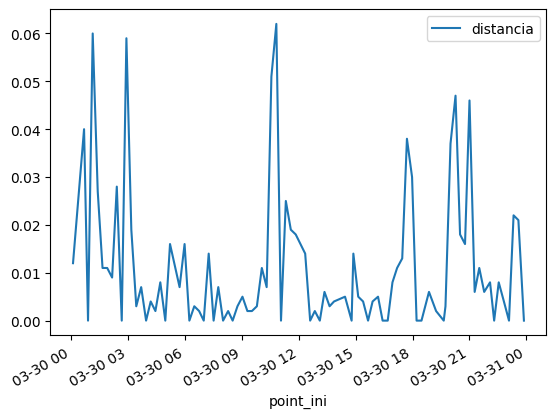

In [55]:
dia.plot(x='point_ini',y='distancia')

In [67]:
import pandas as pd
import numpy as np

# Agrupamos los valores por mes
df_dia = dia.groupby(pd.Grouper(key='point_ini', freq='H'))['distancia'].agg(['count', 'mean'])

len(df_dia)

24

<AxesSubplot: xlabel='point_ini'>

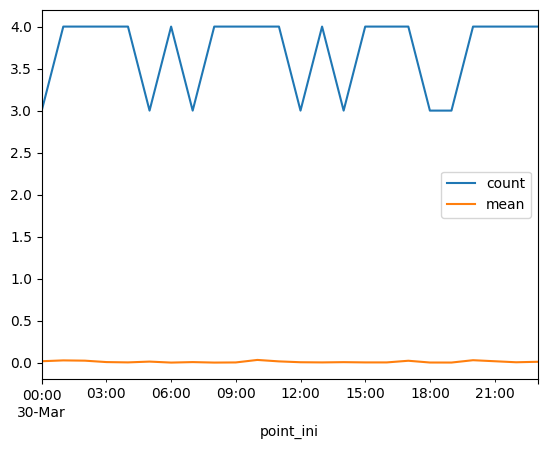

In [64]:
df_dia.plot()

In [179]:
fecha_max= []
for registro in rango_fechas:
    fecha= 
    registros_por_fecha[fecha] += 1

AttributeError: 'str' object has no attribute 'strftime'

In [177]:
fecha_max

[24, 24, 24, 24, 24, 24, 24, 24]

In [169]:
conteo_registros= len(vaca1.value_counts())
conteo_registros


541

In [140]:
rango_fechas = vaca1.Fecha.unique()
rango_fechas


array(['2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01',
       '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05'],
      dtype=object)

In [128]:
macsa.Hora.value_counts()

10:00:36.470    5
19:45:52.756    2
12:45:05.429    1
08:52:29.404    1
09:09:06.043    1
               ..
06:14:22.336    1
06:44:35.389    1
07:44:55.135    1
08:00:02.867    1
22:56:27.913    1
Name: Hora, Length: 4008, dtype: int64

In [125]:
vaca1_= macsa[macsa['UUID']== '0004A30B00F89C52' ]
vaca1_.sort_values(by=['Fecha', 'Hora'])

,UUID,point_ini,point_next,interval_time,distancia,velocidad,tiempo,charge_vel,Fecha,Hora
3434,0004A30B00F89C52,2023-03-29 15:21:58.425,2023-03-29 15:54:20.919,0,0.008,0.172,0.048,0.172,2023-03-29,15:21:58.425
3435,0004A30B00F89C52,2023-03-29 15:54:20.919,2023-03-29 16:10:18.938,1,0.000,0.066,0.000,-0.106,2023-03-29,15:54:20.919
3436,0004A30B00F89C52,2023-03-29 16:10:18.938,2023-03-29 16:23:52.358,0,0.004,0.066,0.063,-0.056,2023-03-29,16:10:18.938
3437,0004A30B00F89C52,2023-03-29 16:23:52.358,2023-03-29 16:40:10.183,0,0.004,0.010,0.422,0.034,2023-03-29,16:23:52.358
3438,0004A30B00F89C52,2023-03-29 16:40:10.183,2023-03-29 16:55:32.502,0,0.000,0.100,0.000,0.090,2023-03-29,16:40:10.183
...,...,...,...,...,...,...,...,...,...,...
3970,0004A30B00F89C52,2023-04-05 14:15:46.087,2023-04-05 15:30:05.877,1,0.002,0.015,0.143,0.007,2023-04-05,14:15:46.087
3971,0004A30B00F89C52,2023-04-05 15:30:05.877,2023-04-05 15:30:22.230,0,0.000,0.055,0.000,0.040,2023-04-05,15:30:05.877
3972,0004A30B00F89C52,2023-04-05 15:30:22.230,2023-04-05 15:30:50.801,0,0.001,0.055,0.027,-0.018,2023-04-05,15:30:22.230
3973,0004A30B00F89C52,2023-04-05 15:30:50.801,2023-04-05 15:31:39.303,0,0.000,0.037,0.000,-0.018,2023-04-05,15:30:50.801


<AxesSubplot: >

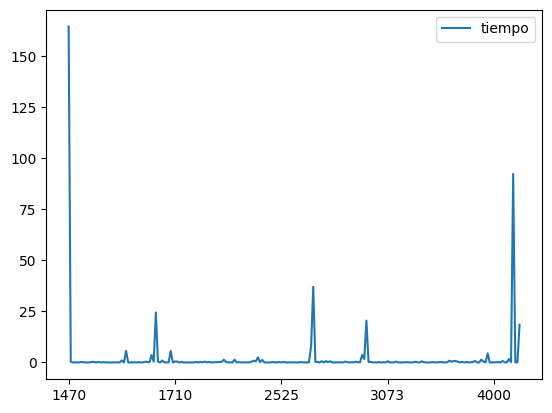

In [126]:
vaca1_d.plot(y='tiempo', use_index=True)

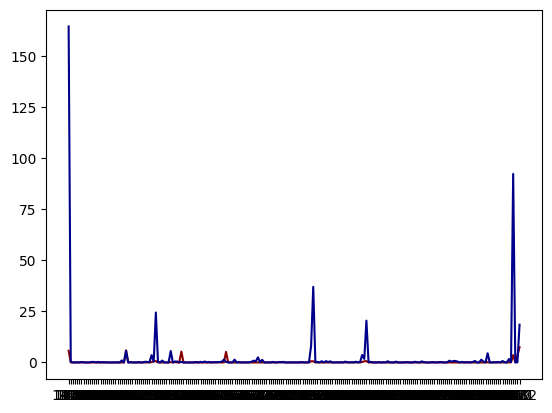

In [123]:
y1= vaca1_d['distancia']
y2= vaca1_d['tiempo']

plt.plot(y1 , color= 'darkred', linestyle='-')
plt.plot(y2, color= 'darkblue', linestyle='-')
plt.show()

In [51]:
def perimetro_aprox(hectarea: float) -> float:
    """
    Calcula el perímetro aproximado de un terreno a partir de su área en hectáreas.
    
    Parámetros:
    -----------
    - hectarea: área del terreno en hectáreas
    
    Retorna:
    -----------
    - perim: perímetro aproximado del terreno en metros
    """
    hect = hectarea  # Asignamos el valor del parámetro hectarea a la variable hect
    lado = math.sqrt(hect) * 10  # Calculamos la longitud del lado de un cuadrado cuya área es igual a hect y multiplicamos por 10
    perim = lado * 4  # Calculamos el perímetro del cuadrado multiplicando la longitud del lado por 4

    return perim

In [52]:
def area_perimetro(latitud: float, longitud: float, hectareas: float) -> gpd.GeoDataFrame:
    """
    Devuelve una GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro de un círculo
    centrado en las coordenadas dadas y con un radio que corresponde al perímetro aproximado de un terreno
    de la misma área que se especifica.
    
    Parámetros:
    -----------
    - latitud: latitud del centro del círculo
    - longitud: longitud del centro del círculo
    - hectareas: área del terreno en hectáreas
    
    Retorna:
    -----------
    - on_perimetro: GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro del círculo
    """
    setle_lat = latitud # Asignamos el valor del parámetro latitud a la variable setle_lat
    setle_lng = longitud # Asignamos el valor del parámetro longitud a la variable setle_lng
    punto_referencia = Point(setle_lng, setle_lat) # Creamos un punto de referencia con las coordenadas setle_lat y setle_lng
    per_kilo = perimetro_aprox(hectareas) # Calculamos el perímetro en metros aproximado a partir del área en hectáreas
    circulo = punto_referencia.buffer(per_kilo/111.32) # Creamos un círculo con el radio igual al perímetro en metros, dividido entre 111.32 km, aproximando a 1 grado en el ecuador
    on_perimetro = gdf[gdf.geometry.within(circulo)] # Filtramos el GeoDataFrame gdf para obtener los puntos dentro del círculo creado anteriormente.
    return on_perimetro

In [53]:
def filter_area_perimetro(data: List[Dict[str, Any]], latitud: float, longitud: float, hectareas: float) -> gpd.GeoDataFrame:
    """
    Devuelve una GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro de un círculo
    centrado en las coordenadas dadas y con un radio que corresponde al perímetro aproximado de un terreno
    de la misma área que se especifica.

    Parámetros:
    -----------
    - data: Lista de diccionarios con los datos a ser incluidos en el GeoDataFrame
    - latitud: latitud del centro del círculo
    - longitud: longitud del centro del círculo
    - hectareas: área del terreno en hectáreas

    Retorna:
    -----------
    - on_perimetro: GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro del círculo
    """
    gdf = gpd.GeoDataFrame(data, crs='EPSG:4326', geometry=gpd.points_from_xy(data.dataRowData_lng, data.dataRowData_lat)) # Creamos un GeoDataFrame a partir de la lista de diccionarios data, estableciendo la proyección y la geometría
    setle_lat = latitud # Asignamos el valor del parámetro latitud a la variable setle_lat
    setle_lng = longitud # Asignamos el valor del parámetro longitud a la variable setle_lng
    punto_referencia = Point(setle_lng, setle_lat) # Creamos un punto de referencia con las coordenadas setle_lat y setle_lng
    per_kilo = perimetro_aprox(hectareas) # Calculamos el perímetro en metros aproximado a partir del área en hectáreas
    circulo = punto_referencia.buffer(per_kilo/111.32) # Creamos un círculo con el radio igual al perímetro en metros, dividido entre 111.32 km, aproximando a 1 grado en el ecuador
    on_perimetro = gdf[gdf.geometry.within(circulo)] # Filtramos el GeoDataFrame gdf para obtener los puntos dentro del círculo creado anteriormente.
    return on_perimetro

In [60]:
on_perimetro= filter_area_perimetro(df,-34.164999,-64.07001,1.09)
uuid_devis= on_perimetro.UUID.unique()
len(uuid_devis)

19

In [61]:
df_filtrado= pd.DataFrame()
for i in df.UUID:
    for i in uuid_devis:
        if i in df.UUID.values:
            df.append
        

/var/folders/5_/gzf1wsls3f76y2tqntkbp17h0000gp/T/ipykernel_30359/2122795460.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  uuid_devis in df.UUID.values


False

In [56]:
def obtener_fecha_inicio_fin(semana: Union[str, datetime.datetime]) -> Tuple[str, str]:
    """
    Función que recibe una semana en formato de fecha y devuelve la fecha de inicio y finalización de esa semana.
    
    Parámetros:
    -----------
    - semana (str o datetime): Semana en formato de fecha. Debe estar en formato 'YYYY-MM-DD'.
    
    Retorna:
    -----------
    - fecha_inicio (str): Fecha de inicio de la semana en formato 'YYYY-MM-DD'.
    - fecha_fin (str): Fecha de finalización de la semana en formato 'YYYY-MM-DD'.
    """
    
    # Convertimos 'semana' a un objeto datetime si es un string
    if isinstance(semana, str):
        semana = datetime.datetime.strptime(semana, '%Y-%m-%d')
        
    # Obtenemos el día de la semana correspondiente a 'semana'
    dia_semana = semana.weekday()

    # Calculamos la fecha de inicio y fin de la semana correspondiente a 'semana'
    fecha_inicio = semana - datetime.timedelta(days=dia_semana)
    fecha_fin = fecha_inicio + datetime.timedelta(days=6)

    # Convertimos las fechas de inicio y fin a formato string
    fecha_inicio = fecha_inicio.strftime('%Y-%m-%d')
    fecha_fin = fecha_fin.strftime('%Y-%m-%d')
    return fecha_inicio, fecha_fin

In [57]:
semana = '2022-08-01'  # Semana en formato 'YYYY-MM-DD'
fecha_inicio, fecha_fin = obtener_fecha_inicio_fin(semana)
print('Fecha de inicio de la semana:', fecha_inicio)
print('Fecha de finalización de la semana:', fecha_fin)

Fecha de inicio de la semana: 2022-08-01
Fecha de finalización de la semana: 2022-08-07


In [ ]:
def data_dias_mas_registros(nombre,data=df_row):
    data_finca = setle_clean(nombre)
    prueba = filtro_finca(data,data_finca['latitud_c'],data_finca['longitud_c'],data_finca['hectares'])
    vacas= prueba.UUID.unique()
    data_nuevo={}
    for i in vacas:
        data=data_devices(prueba,i)
        data_nuevo[i]=dataframe_interview_vaca(data)
    merge_data= pd.concat(data_nuevo.values(),keys=data_nuevo.keys())
    merge_data.reset_index(level=0,inplace=True)
    merge_data.rename(columns={'level_0':'UUID'},inplace=True)
    merge_data.reset_index(inplace=True)
    merge_data.set_index("UUID")
    merge_data.drop(columns="index",inplace=True)
    for i in merge_data:
        a= data_finca.groupby('point_ini').count()
        orden= a['UUID'].sort_values(ascending=False).head(4)
        lista= list(orden.index)
    df_sem= lista
    return df_sem

In [ ]:
def informacion_por_establecimiento(nombre: str):
    merge_data = data_interview(nombre)
    merge_data.point_ini= merge_data.point_ini.astype(str)
    merge_data.point_next= merge_data.point_next.astype(str)
    return JSONResponse(content= json.loads(merge_data.to_json()))